In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats as st
from sklearn.linear_model import LinearRegression
import seaborn as sns

In [301]:
Spot = pd.read_excel('BDHData.xlsx',index_col=0,sheet_name = 'Spot')
Bid = pd.read_excel('BDHData.xlsx',index_col=0,sheet_name = 'Bid')
Ask = pd.read_excel('BDHData.xlsx',index_col=0,sheet_name = 'Ask')
Spread = abs(Bid-Ask)
Spread_pct = (Spread/Spot)*100
RollingVolatility_1M = pd.read_excel('BDHData.xlsx',index_col=0,sheet_name = 'Vol30D').iloc[1:,:]
RollingVolatility_3M = pd.read_excel('BDHData.xlsx',index_col=0,sheet_name = 'Vol90D').iloc[3:,:]
RollingVolatility_6M = pd.read_excel('BDHData.xlsx',index_col=0,sheet_name = 'Vol180D').iloc[6:,:]
RollingVolatility_9M = pd.read_excel('BDHData.xlsx',index_col=0,sheet_name = 'Vol260D').iloc[9:,:]
RollingVolatility_12M = pd.read_excel('BDHData.xlsx',index_col=0,sheet_name = 'Vol360D').iloc[12:,:]
RollingVolatility_12MRAW = pd.read_excel('BDHData.xlsx',index_col=0,sheet_name = 'Vol360D')

AnnualInterestRates = pd.read_excel('Interest_Rates.xlsx',index_col=0,sheet_name = 'IR_EMs')
AnnualInterestRates = AnnualInterestRates.apply(lambda row: row.fillna(row.mean()), axis=1)

Unique_Countries = ['Poland','South Africa', 'Chile', 'Nigeria', 'Korea, Rep.', 'Portugal', \
                    'Kazakhstan', 'China', 'Philippines', 'New Zealand', 'India', 'Bangladesh', \
                    'Malaysia', 'Indonesia', 'Colombia', 'Mexico', 'Algeria', \
                    'Greece', 'Argentina', 'Brazil', 'Hungary', 'Vietnam', 'Israel', \
                    'Czech Republic', 'Russian Federation', 'Thailand', 'Romania','Ukraine','Turkey',\
                    'Peru','Pakistan']
Country_Ticker = zip(Unique_Countries,list(Spot.columns))
CountryToTickers = dict(Country_Ticker)
Ticker_Country = zip(list(Spot.columns),Unique_Countries)
TickersToCountries = dict(Ticker_Country)

# Spot, Excess, TC Returns  & Interest-Rate-Differentials

In [3]:
def Returns_IRs_nM(n):
    Returns_nM = -1*(((Spot.pct_change()+1).rolling(n).apply(lambda x: (np.product(x)))-1)*100).dropna(how = 'all')
    InterestRates_n = AnnualInterestRates.apply(lambda x: (((x/100)+1)**(n/12)-1)*100)
    IRDs = []
    for year in AnnualInterestRates.columns:
        IRDi = []
        for country in InterestRates_n.index[:-1]:
            IRDi.append(InterestRates_n[year].loc[country]-InterestRates_n[year].loc['United States'])
        IRDs.append(IRDi)
    IRD_n = pd.DataFrame(IRDs, columns = InterestRates_n.index[:-1], index = InterestRates_n.columns).T
    
    ExReturns_nM = []
    for date in Returns_nM.index:
        year = str(date.year)
        exreturns_countryi = []
    
        for ticker in Returns_nM.columns:
            exreturns_countryi.append(IRD_n[year].loc[TickersToCountries[ticker]]+Returns_nM[ticker].loc[date])
        ExReturns_nM.append(exreturns_countryi)
    Excess_Returns_nM = pd.DataFrame(ExReturns_nM,columns=Returns_nM.columns,index = Returns_nM.index)
    
    Spread_pct = (Spread/Spot)*100
    Spread_pct.iloc[n:]
    TC_LongExcessReturns_nM = pd.DataFrame(0.,columns=Returns_nM.columns,index = Returns_nM.index)
    TC_ShortExcessReturns_nM = pd.DataFrame(0.,columns=Returns_nM.columns,index = Returns_nM.index)
    for date in Excess_Returns_nM.index:
        for ticker in Excess_Returns_nM.columns:
            value = Excess_Returns_nM[ticker].loc[date]
            TC_LongExcessReturns_nM[ticker].loc[date] = value - Spread_pct[ticker].loc[date]
            TC_ShortExcessReturns_nM[ticker].loc[date] = (-1*value) - Spread_pct[ticker].loc[date]
                
    return Returns_nM,Excess_Returns_nM,TC_LongExcessReturns_nM,TC_ShortExcessReturns_nM,InterestRates_n,IRD_n

In [4]:
Returns_1M,Excess_Returns_1M,TCLongExcessReturns_1M,TCShortExcessReturns_1M,InterestRates_1M,IRD_1M = Returns_IRs_nM(1)
Returns_3M,Excess_Returns_3M,TCLongExcessReturns_3M,TCShortExcessReturns_3M,InterestRates_3M,IRD_3M = Returns_IRs_nM(3)
Returns_6M,Excess_Returns_6M,TCLongExcessReturns_6M,TCShortExcessReturns_6M,InterestRates_6M,IRD_6M = Returns_IRs_nM(6)
Returns_9M,Excess_Returns_9M,TCLongExcessReturns_9M,TCShortExcessReturns_9M,InterestRates_9M,IRD_9M = Returns_IRs_nM(9)
Returns_12M,Excess_Returns_12M,TCLongExcessReturns_12M,TCShortExcessReturns_12M,InterestRates_12M,IRD_12M = Returns_IRs_nM(12)

# Emerging Country Criteria & Selection

In [267]:
GDPgrowth.columns[28:-1]

Index([1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009,
       2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019],
      dtype='object')

In [250]:
a = pd.read_excel('Data_Extract_From_World_Development_Indicators.xlsx',index_col=0,sheet_name = 'GDP')
GDP = a.drop(a.columns[0], axis=1)/1000000000

GDPgrowth = (GDP.pct_change(axis='columns')+1).T.rolling(10).apply(lambda x: np.product(x)).T.dropna(how='all',axis=1).dropna(how='all')

c = pd.read_excel('Income&business.xlsx',index_col=0,sheet_name = 'GNI')
GNI = c.drop(c.columns[0],axis=1).dropna(how='all',axis=1)

#Function to be used to select interesction of criteria.
def IntersectionOfCriteria(A,B): 
    overlap =[]
    for k in range(len(A)):
        overlapi =[]
        for i in range(len(A[k])):
            for j in range(len(B[k])):
                if A[k][i]==B[k][j]:
                    overlapi.append(A[k][i])
        overlap.append(overlapi)
    return overlap

In [251]:
#Criteria1: GDP SIZE > WORLD GDP x 0.2%
TopGDP =[]
for i in GDP.columns[38:-1]: # so that it coincides with GDPgrowthindex years
    TopGDPi = []
    for j in GDP.index[:-1]:
        if GDP[i].loc[j] > GDP[i].loc['World']*0.002:
            TopGDPi.append(j)
    #print(len(TopGDPi))
    TopGDP.append(TopGDPi)

In [280]:
#Criteria2: SUSTAINED(10YRS) GDP GROWTH > WORLD GDP GROWTH + 20%
TopGrowth = []
for year in GDPgrowth.columns[29:]: #looping through each year
    TopGrowthi = [] #new array for each year top growth countries
    for country in GDPgrowth.index[:-1]: #looping through each country
        if GDPgrowth[year].loc[country]>GDPgrowth[year].loc['World']+0.2:
            TopGrowthi.append(country)
    #print(len(TopGrowthi))
    TopGrowth.append(TopGrowthi)

In [281]:
#Criteria3: GNI PER CAPITA < WORLD GNI PER CAPITA x 2.5
GNIcriteria = []
for year in GNI.columns[8:-1]:
    GNIcriteriai = []
    for country in GNI.index[:-1]:
        if GNI[year].loc[country]< 2.5*GNI[year].loc['World']:
            GNIcriteriai.append(country)
    #print(len(GNIcriteriai))
    GNIcriteria.append(GNIcriteriai)

In [282]:
YearlyCriteria = []
for i in range(len(GDPgrowth.columns[29:])):
    YearlyCriteria.append([GDPgrowth.columns[29:][i],IntersectionOfCriteria(IntersectionOfCriteria(TopGDP,TopGrowth),GNIcriteria)[i]])
UniqueCountries = list(set(np.concatenate(IntersectionOfCriteria(IntersectionOfCriteria(TopGDP,TopGrowth),GNIcriteria),axis=0)))
Yearly_Criteria = pd.DataFrame(YearlyCriteria,columns= ['Year','EmergingCountries']).set_index('Year')

36

## Here we remove countries that are pegged or have other major risks / economic issues

In [11]:
YearlyEmergingCountries = [] #Removing excluded countries
YearlyEmergingTickers = []
for i in range(len(YearlyCriteria)):
    emergingcountriesi = []
    emergingtickersi = []
    #print(GDPgrowth.columns[29:][13])
    #print(GDPgrowth.columns[29:][17])
    for country in YearlyCriteria[i][1]:
        if country != 'Iran, Islamic Rep.' and country != 'Venezuela, RB' and country != 'Iraq'\
        and country != 'Egypt, Arab Rep.' and country != 'Myanmar':
        #and ([i,country]!=[12,'Myanmar']) and ([i,country]!=[13,'Myanmar'])\
        #and ([i,country]!=[17,'Egypt, Arab Rep.']):
            emergingcountriesi.append(country)
            emergingtickersi.append(CountryToTickers[country])
    YearlyEmergingCountries.append([GDPgrowth.columns[29:][i],emergingcountriesi])
    YearlyEmergingTickers.append([GDPgrowth.columns[29:][i],emergingtickersi])
Yearly_EmergingCountries = pd.DataFrame(YearlyEmergingCountries,columns = ['Year','EmergingCountries']).set_index('Year')
Yearly_EmergingTickers = pd.DataFrame(YearlyEmergingTickers,columns = ['Year','EmergingCountries']).set_index('Year')

In [12]:
ERC = pd.read_excel('CountriesAndPegs.xlsx',index_col=0,sheet_name = 'ERClassifications')#IMF Exchange rate classifications.
YearlyUnpeggedCountries = []
YearlyUnpeggedTickers = []
for i in range(len(ERC.index)):
    unpeggedcountriesi = []
    unpeggedtickersi = []
    for country in YearlyEmergingCountries[i][1]:
        if (ERC[country].loc[ERC.index[i]]) !=1:
            unpeggedcountriesi.append(country)
            unpeggedtickersi.append(CountryToTickers[country])
    YearlyUnpeggedCountries.append([ERC.index[i],unpeggedcountriesi])
    YearlyUnpeggedTickers.append([ERC.index[i],unpeggedtickersi])
Yearly_UnpeggedCountries = pd.DataFrame(YearlyUnpeggedCountries,columns = ['Year','EmergingCountries']).set_index('Year')
Yearly_UnpeggedTickers = pd.DataFrame(YearlyUnpeggedTickers,columns = ['Year','EmergingCountries']).set_index('Year')

In [13]:
YearlyUnpegged1and2Countries = []
YearlyUnpegged1and2Tickers = []
for i in range(len(ERC.index)):
    unpeggedcountriesi = []
    unpeggedtickersi = []
    for country in YearlyEmergingCountries[i][1]:
        if (ERC[country].loc[ERC.index[i]]) != 1 and (ERC[country].loc[ERC.index[i]])!=2 :
            unpeggedcountriesi.append(country)
            unpeggedtickersi.append(CountryToTickers[country])
    YearlyUnpegged1and2Countries.append([ERC.index[i],unpeggedcountriesi])
    YearlyUnpegged1and2Tickers.append([ERC.index[i],unpeggedtickersi])
Yearly_Unpegged1and2Countries = pd.DataFrame(YearlyUnpegged1and2Countries,columns = ['Year','EmergingCountries']).set_index('Year')
Yearly_Unpegged1and2Tickers = pd.DataFrame(YearlyUnpegged1and2Tickers,columns = ['Year','EmergingCountries']).set_index('Year')

# Portfolio formation - Excess Returns

In [190]:
def CurrencyMomentumPortfolios(Yearly_EmergingTickers,Returns_fM,Returns_hM,f,h,split,\
                               RollingVolatility_fM, ranking_system, weighting_system,\
                               TCLongExcessReturns_hM='a',TCShortExcessReturns_hM='b',TC = 'no'):
    
    LongPortfolioReturns_f_h = pd.DataFrame(0.,columns = Returns_fM.columns,index=Returns_fM.index[1:])
    ShortPortfolioReturns_f_h = pd.DataFrame(0.,columns = Returns_fM.columns,index=Returns_fM.index[1:])

    for i in np.arange(0,len(Returns_fM)-h,h):
        if i+h<len(Returns_hM):
            year_i = Returns_fM.index[i].year
            
        #RANKING
            if ranking_system == 'returns':
                ECReturnsi = Returns_fM.iloc[i][Yearly_EmergingTickers.loc[year_i][0]]
                winners = ECReturnsi.nlargest(int(np.round(len(ECReturnsi)/split))) 
                losers = ECReturnsi.nsmallest(int(np.round(len(ECReturnsi)/split)))
            elif ranking_system == 'sharpe':
                ECReturnsi = Returns_fM.iloc[i][Yearly_EmergingTickers.loc[year_i][0]]\
                                   /RollingVolatility_fM.iloc[i][Yearly_EmergingTickers.loc[year_i][0]]
                winners = ECReturnsi.nlargest(int(np.round(len(ECReturnsi)/split))) 
                losers = ECReturnsi.nsmallest(int(np.round(len(ECReturnsi)/split)))
                
        #WEIGHTING
            if weighting_system == 'equal':
                Weights = pd.DataFrame([list(winners.index)+list(losers.index),[1/len(winners+losers)]*len(winners+losers)]\
                                   ,index = ['Tickers','Weights']).T.set_index('Tickers')

            elif weighting_system == 'returns':
                weight = []
                totalweights = abs(Returns_fM[list(winners.index)+list(losers.index)].iloc[i]).sum()
                for ticker in (list(winners.index)+list(losers.index)):
                    weight.append([ticker,abs(Returns_fM[ticker].iloc[i])/totalweights])
                Weights = pd.DataFrame(weight,columns=['Tickers','Weights']).set_index('Tickers')
                
            elif weighting_system == 'sharpe':
                Weights = pd.DataFrame(columns = ['Tickers','Weights'])
                counter = 0
                for ticker in (list(winners.index)+list(losers.index)):
                    weight = RollingVolatility_fM[ticker].iloc[i]\
                    /RollingVolatility_fM[list(winners.index)+list(losers.index)].iloc[i].sum()
                    Weights.loc[counter] = [ticker,weight]
                    counter+=1
                Weights = Weights.set_index('Tickers')
    
            #RETURNS
            if TC == 'no':
                for ticker in winners.index:
                    LongPortfolioReturns_f_h.iloc[i][ticker] = Weights.loc[ticker][0]*Returns_hM.iloc[i+h][ticker]
                for ticker in losers.index:
                    ShortPortfolioReturns_f_h.iloc[i][ticker] = Weights.loc[ticker][0]*-Returns_hM.iloc[i+h][ticker]
            elif TC == 'yes':
                for ticker in winners.index:
                    LongPortfolioReturns_f_h.iloc[i][ticker] = Weights.loc[ticker][0]*TCLongExcessReturns_hM.iloc[i+h][ticker]
                for ticker in losers.index:
                    ShortPortfolioReturns_f_h.iloc[i][ticker] = Weights.loc[ticker][0]*TCShortExcessReturns_hM.iloc[i+h][ticker]

    LongPortfolioReturns_f_h = LongPortfolioReturns_f_h.replace(0,np.nan).dropna(how='all',axis=0)
    ShortPortfolioReturns_f_h = ShortPortfolioReturns_f_h.replace(0,np.nan).dropna(how='all',axis=0)
    
    LongPortfolioReturns_f_h = LongPortfolioReturns_f_h.replace(np.nan,0)
    ShortPortfolioReturns_f_h = ShortPortfolioReturns_f_h.replace(np.nan,0)
    TotalPortfolioReturns_f_h = LongPortfolioReturns_f_h + ShortPortfolioReturns_f_h
    
    return TotalPortfolioReturns_f_h, LongPortfolioReturns_f_h, ShortPortfolioReturns_f_h


# Portfolio results

In [322]:
#Benchmark Excess Returns Results 1 holding period 
BenchmarkTotal_1_1,BenchmarkLong_1_1,BenchmarkShort_1_1 = CurrencyMomentumPortfolios(Yearly_EmergingTickers,Excess_Returns_1M,Excess_Returns_1M,1,1,3,RollingVolatility_1M,'returns','equal')
BenchmarkTotal_3_1,BenchmarkLong_3_1,BenchmarkShort_3_1 = CurrencyMomentumPortfolios(Yearly_EmergingTickers,Excess_Returns_3M,Excess_Returns_1M,3,1,3,RollingVolatility_3M,'returns','equal')
BenchmarkTotal_6_1,BenchmarkLong_6_1,BenchmarkShort_6_1 = CurrencyMomentumPortfolios(Yearly_EmergingTickers,Excess_Returns_6M,Excess_Returns_1M,6,1,3,RollingVolatility_6M,'returns','equal')
BenchmarkTotal_9_1,BenchmarkLong_9_1,BenchmarkShort_9_1 = CurrencyMomentumPortfolios(Yearly_EmergingTickers,Excess_Returns_9M,Excess_Returns_1M,9,1,3,RollingVolatility_9M,'returns','equal')
BenchmarkTotal_12_1,BenchmarkLong_12_1,BenchmarkShort_12_1 = CurrencyMomentumPortfolios(Yearly_EmergingTickers,Excess_Returns_12M,Excess_Returns_1M,12,1,3,RollingVolatility_12M,'returns','equal')

In [343]:
print(BenchmarkTotal_6_1.T.sum().max())
print(BenchmarkLong_6_1.T.sum().max())
print(BenchmarkShort_6_1.T.sum().max())

5.089474070082833
3.434377926732786
6.989213616758843


In [335]:
#Benchmark Spot Returns Results 1 holding period 
BenchmarkSpotTotal_1_1,BenchmarkSpotLong_1_1,BenchmarkSpotShort_1_1 = CurrencyMomentumPortfolios(Yearly_EmergingTickers,Returns_1M,Returns_1M,1,1,3,RollingVolatility_1M,'returns','equal')
BenchmarkSpotTotal_3_1,BenchmarkSpotLong_3_1,BenchmarkSpotShort_3_1 = CurrencyMomentumPortfolios(Yearly_EmergingTickers,Returns_3M,Returns_1M,3,1,3,RollingVolatility_3M,'returns','equal')
BenchmarkSpotTotal_6_1,BenchmarkSpotLong_6_1,BenchmarkSpotShort_6_1 = CurrencyMomentumPortfolios(Yearly_EmergingTickers,Returns_6M,Returns_1M,6,1,3,RollingVolatility_6M,'returns','equal')
BenchmarkSpotTotal_9_1,BenchmarkSpotLong_9_1,BenchmarkSpotShort_9_1 = CurrencyMomentumPortfolios(Yearly_EmergingTickers,Returns_9M,Returns_1M,9,1,3,RollingVolatility_9M,'returns','equal')
BenchmarkSpotTotal_12_1,BenchmarkSpotLong_12_1,BenchmarkSpotShort_12_1 = CurrencyMomentumPortfolios(Yearly_EmergingTickers,Returns_12M,Returns_1M,12,1,3,RollingVolatility_12M,'returns','equal')

In [347]:
print(BenchmarkSpotTotal_3_1.T.sum().max())
print(BenchmarkSpotLong_3_1.T.sum().max())
print(BenchmarkSpotShort_3_1.T.sum().max())

6.560073451947203
3.2403126419788317
7.795140145887114


In [713]:
#BenchmarkSpotTotal_6_1.T.sum().to_excel('Portfolios/total.xlsx')
#BenchmarkSpotLong_6_1.T.sum().to_excel('Portfolios/long.xlsx')
#BenchmarkSpotShort_6_1.T.sum().to_excel('Portfolios/short.xlsx')

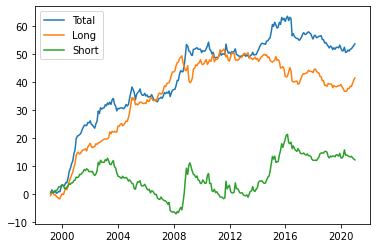

In [16]:
plt.plot(BenchmarkTotal_1_1.T.sum().cumsum(),label = 'Total');
plt.plot(BenchmarkLong_1_1.T.sum().cumsum(),label = 'Long');
plt.plot(BenchmarkShort_1_1.T.sum().cumsum(),label = 'Short');
plt.legend();

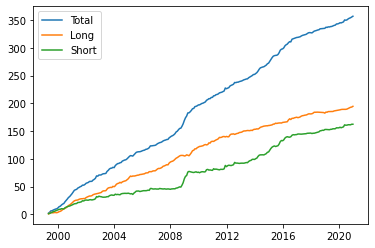

In [704]:
plt.plot(BenchmarkTotal_3_1.T.sum().cumsum(),label = 'Total');
plt.plot(BenchmarkLong_3_1.T.sum().cumsum(),label = 'Long');
plt.plot(BenchmarkShort_3_1.T.sum().cumsum(),label = 'Short');
plt.legend();

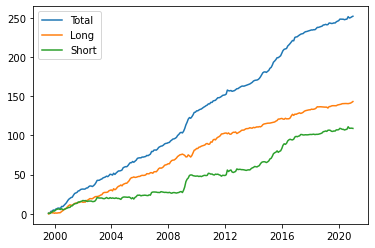

In [700]:
plt.plot(BenchmarkTotal_6_1.T.sum().cumsum(),label = 'Total');
plt.plot(BenchmarkLong_6_1.T.sum().cumsum(),label = 'Long');
plt.plot(BenchmarkShort_6_1.T.sum().cumsum(),label = 'Short');
plt.legend();

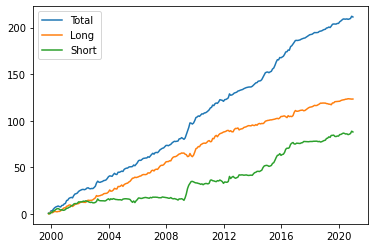

In [701]:
plt.plot(BenchmarkTotal_9_1.T.sum().cumsum(),label = 'Total');
plt.plot(BenchmarkLong_9_1.T.sum().cumsum(),label = 'Long');
plt.plot(BenchmarkShort_9_1.T.sum().cumsum(),label = 'Short');
plt.legend();

In [323]:
#print out all results and combinations. Selecting spot or excess, then weight within loop
#Rets = [[1,Returns_1M,RollingVolatility_1M],[3,Returns_3M,RollingVolatility_3M],\
#        [6,Returns_6M,RollingVolatility_6M],[9,Returns_9M,RollingVolatility_9M],\
#        [12,Returns_12M,RollingVolatility_12M]]
Rets = [[1,Excess_Returns_1M,RollingVolatility_1M],[3,Excess_Returns_3M,RollingVolatility_3M],\
        [6,Excess_Returns_6M,RollingVolatility_6M],[9,Excess_Returns_9M,RollingVolatility_9M],\
        [12,Excess_Returns_12M,RollingVolatility_12M]]

TotalAverageReturns_df = pd.DataFrame(0.,columns = [1,3,6,9,12],index=[1,3,6,9,12])
LongAverageReturns_df = pd.DataFrame(0.,columns = [1,3,6,9,12],index=[1,3,6,9,12])
ShortAverageReturns_df = pd.DataFrame(0.,columns = [1,3,6,9,12],index=[1,3,6,9,12])
AnnualizedSharpeRatiosTotal_df = pd.DataFrame(0.,columns = [1,3,6,9,12],index=[1,3,6,9,12])
AnnualizedSharpeRatiosLong_df = pd.DataFrame(0.,columns = [1,3,6,9,12],index=[1,3,6,9,12])
AnnualizedSharpeRatiosShort_df = pd.DataFrame(0.,columns = [1,3,6,9,12],index=[1,3,6,9,12])
SharpeTotalpval = pd.DataFrame(columns = [1,3,6,9,12],index=[1,3,6,9,12])
SharpeLongpval = pd.DataFrame(columns = [1,3,6,9,12],index=[1,3,6,9,12])
SharpeShortpval = pd.DataFrame(columns = [1,3,6,9,12],index=[1,3,6,9,12])

StdTotal_df = pd.DataFrame(0.,columns = [1,3,6,9,12],index=[1,3,6,9,12])
StdLong_df = pd.DataFrame(0.,columns = [1,3,6,9,12],index=[1,3,6,9,12])
StdShort_df = pd.DataFrame(0.,columns = [1,3,6,9,12],index=[1,3,6,9,12])
TotalTtest = pd.DataFrame(columns = [1,3,6,9,12],index=[1,3,6,9,12])
LongTtest = pd.DataFrame(columns = [1,3,6,9,12],index=[1,3,6,9,12])
ShortTtest = pd.DataFrame(columns = [1,3,6,9,12],index=[1,3,6,9,12])
TotalPval = pd.DataFrame(columns = [1,3,6,9,12],index=[1,3,6,9,12])
LongPval = pd.DataFrame(columns = [1,3,6,9,12],index=[1,3,6,9,12])
ShortPval = pd.DataFrame(columns = [1,3,6,9,12],index=[1,3,6,9,12])

for i in range(5): #f
    for j in range(5): #h
        total,long,short = CurrencyMomentumPortfolios(Yearly_EmergingTickers,Rets[i][1],\
                            Rets[j][1],Rets[i][0],Rets[j][0],3,Rets[i][2],'returns','equal')
        #TotalTtest.iat[i,j] = st.ttest_1samp(total.T.sum(),0)[0]
        #LongTtest.iat[i,j] = st.ttest_1samp(long.T.sum(),0)[0]
        #ShortTtest.iat[i,j] = st.ttest_1samp(short.T.sum(),0)[0]
        TotalPval.iat[i,j] = st.ttest_1samp(total.T.sum(),0)[1]
        LongPval.iat[i,j] = st.ttest_1samp(long.T.sum(),0)[1]
        ShortPval.iat[i,j] = st.ttest_1samp(short.T.sum(),0)[1]
        #AnnualizedSharpeRatiosTotal_df.iloc[i,j] = ((((total.T.sum().mean()/100)+1)**(12/Rets[j][0])-1)*100)/(total.T.sum().std()*np.sqrt(12/Rets[j][0]))
        #AnnualizedSharpeRatiosLong_df.iloc[i,j] = ((((long.T.sum().mean()/100)+1)**(12/Rets[j][0])-1)*100)/(long.T.sum().std()*np.sqrt(12/Rets[j][0]))
        #AnnualizedSharpeRatiosShort_df.iloc[i,j] = ((((short.T.sum().mean()/100)+1)**(12/Rets[j][0])-1)*100)/(short.T.sum().std()*np.sqrt(12/Rets[j][0]))
        #SharpeTotalpval.iloc[i,j] = st.ttest_1samp(total.T.sum()/total.T.std(),0)[1]
        #SharpeLongpval.iloc[i,j] = st.ttest_1samp(long.T.sum()/long.T.std(),0)[1]
        #SharpeShortpval.iloc[i,j] = st.ttest_1samp(short.T.sum()/short.T.std(),0)[1]
                
        #StdTotal_df.iloc[i,j] = total.T.sum().std()
        #StdLong_df.iloc[i,j] = long.T.sum().std()
        #StdShort_df.iloc[i,j] = short.T.sum().std()
        TotalAverageReturns_df.iloc[i,j] = ((((total.T.sum().mean()/100)+1)**(12/Rets[j][0])-1)*100)
        LongAverageReturns_df.iloc[i,j] = ((((long.T.sum().mean()/100)+1)**(12/Rets[j][0])-1)*100)
        ShortAverageReturns_df.iloc[i,j] = ((((short.T.sum().mean()/100)+1)**(12/Rets[j][0])-1)*100)

In [325]:
TotalPval

,1,3,6,9,12
1,0.004051,0.359419,0.193519,0.435367,0.903284
3,0.0,0.551842,0.824095,0.133389,0.616181
6,0.0,0.0,0.791213,0.376989,0.77229
9,0.0,0.0,0.000062,0.711883,0.665598
12,0.0,0.0,0.0,0.000356,0.917508


In [326]:
#TotalAverageReturns_df.to_excel('Portfolios/TotalReturnsSWeight.xlsx',sheet_name='Total')
#ShortAverageReturns_df.to_excel('Portfolios/Short.xlsx',sheet_name='Short')
#LongAverageReturns_df.to_excel('Portfolios/Long.xlsx',sheet_name='Long')
#AnnualizedSharpeRatiosTotal_df.to_excel('Portfolios/TotalSharpe.xlsx',sheet_name='Long')
#AnnualizedSharpeRatiosLong_df.to_excel('Portfolios/LongSharpe.xlsx',sheet_name='Long')
#AnnualizedSharpeRatiosShort_df.to_excel('Portfolios/ShortSharpe.xlsx',sheet_name='Long')
#SharpeTotalpval.to_excel('Portfolios/TotalSharpePVAL.xlsx',sheet_name='Long')
#SharpeLongpval.to_excel('Portfolios/LongSharpePVAL.xlsx',sheet_name='Long')
#SharpeShortpval.to_excel('Portfolios/ShortSharpePVAL.xlsx',sheet_name='Long')
#StdShort_df.to_excel('Portfolios/TotalStd.xlsx',sheet_name='Long')
#StdLong_df.to_excel('Portfolios/LongStd.xlsx',sheet_name='Long')
#StdShort_df.to_excel('Portfolios/ShortStd.xlsx',sheet_name='Long')      

#TotalTtest.to_excel('Portfolios/TotalT.xlsx',sheet_name='Long')
#LongTtest.to_excel('Portfolios/LongT.xlsx',sheet_name='Long')
#ShortTtest.to_excel('Portfolios/ShortT.xlsx',sheet_name='Long')
TotalPval.to_excel('Portfolios/TotalP.xlsx',sheet_name='Long')
LongPval.to_excel('Portfolios/LongP.xlsx',sheet_name='Long')
ShortPval.to_excel('Portfolios/ShortP.xlsx',sheet_name='Long')

In [447]:
#print out all results and combinations.
Rets = [[1,Returns_1M,RollingVolatility_1M],[3,Returns_3M,RollingVolatility_3M],\
        [6,Returns_6M,RollingVolatility_6M],[9,Returns_9M,RollingVolatility_9M],\
        [12,Returns_12M,RollingVolatility_12M]]
Rets = [[1,Excess_Returns_1M,RollingVolatility_1M],[3,Excess_Returns_3M,RollingVolatility_3M],\
        [6,Excess_Returns_6M,RollingVolatility_6M],[9,Excess_Returns_9M,RollingVolatility_9M],\
        [12,Excess_Returns_12M,RollingVolatility_12M]]

for i in range(5): #f
    for j in range(5): #h
        for k in ['returns','sharpe']:
            for l in ['equal','returns','sharpe']:
                print([Rets[i][0],Rets[j][0],'ranking = ',k,'weighting =',l])
                total,long,short = CurrencyMomentumPortfolios(Yearly_EmergingTickers,Rets[i][1],\
                                        Rets[j][1],Rets[i][0],Rets[j][0],3,Rets[i][2],k,l)

                print((st.ttest_1samp(total.T.sum(),0)[0],st.ttest_1samp(total.T.sum(),0)[1]))
                print([((((total.T.sum().mean()/100)+1)**(12/Rets[j][0])-1)*100),\
                      ((((long.T.sum().mean()/100)+1)**(12/Rets[j][0])-1)*100),
                      ((((short.T.sum().mean()/100)+1)**(12/Rets[j][0])-1)*100)],'\n')

[1, 1, 'ranking = ', 'returns', 'weighting =', 'equal']
(2.7548863363671576, 0.006282885258926379)
[2.293831591124329, -0.9419257104630319, 3.2639123122004676] 

[1, 1, 'ranking = ', 'returns', 'weighting =', 'returns']


KeyboardInterrupt: 

# Transaction cost included results

In [264]:
#Print out all TC adjusted results
Rets = [[1,Excess_Returns_1M,RollingVolatility_1M],[3,Excess_Returns_3M,RollingVolatility_3M],\
        [6,Excess_Returns_6M,RollingVolatility_6M],[9,Excess_Returns_9M,RollingVolatility_9M],\
        [12,Excess_Returns_12M,RollingVolatility_12M]]
TCRets = [[TCLongExcessReturns_1M,TCShortExcessReturns_1M],[TCLongExcessReturns_3M,TCShortExcessReturns_3M],\
         [TCLongExcessReturns_6M,TCShortExcessReturns_6M],[TCLongExcessReturns_9M,TCShortExcessReturns_9M],\
         [TCLongExcessReturns_12M,TCShortExcessReturns_12M]]

for i in range(5): #f
    for j in range(5): #h
        for k in ['returns','sharpe']:
            for l in ['equal','returns','sharpe']:
                print([Rets[i][0],Rets[j][0],'ranking = ',k,'weighting =',l])
                
                total,long,short = CurrencyMomentumPortfolios(Yearly_EmergingTickers,Rets[i][1],\
                                        Rets[j][1],Rets[i][0],Rets[j][0],3,Rets[i][2],k,l,\
                                    TCRets[j][0],TCRets[j][1],'yes')
                
                print([((((total.T.sum().mean()/100)+1)**(12/Rets[j][0])-1)*100),\
                      ((((long.T.sum().mean()/100)+1)**(12/Rets[j][0])-1)*100),
                      ((((short.T.sum().mean()/100)+1)**(12/Rets[j][0])-1)*100)],'\n')

[1, 1, 'ranking = ', 'returns', 'weighting =', 'equal']
[-1.1987966551397, 0.20964155786629135, -1.405735435311073] 

[1, 1, 'ranking = ', 'returns', 'weighting =', 'returns']
[1.1376963744595292, 1.4564453812145217, -0.31455148981867076] 

[1, 1, 'ranking = ', 'returns', 'weighting =', 'sharpe']
[-3.9264160266535675, -1.7509947201558407, -2.210967871103331] 

[1, 1, 'ranking = ', 'sharpe', 'weighting =', 'equal']
[-0.743404996155661, 0.8966165379646451, -1.6266479719093008] 

[1, 1, 'ranking = ', 'sharpe', 'weighting =', 'returns']
[1.0564612806003293, 1.9499440387183542, -0.8777994043844051] 

[1, 1, 'ranking = ', 'sharpe', 'weighting =', 'sharpe']
[-4.38661472281181, -1.0173369323130177, -3.40105344299515] 

[1, 3, 'ranking = ', 'returns', 'weighting =', 'equal']
[-0.35533704096037955, 0.14407481970635239, -0.49887255847015366] 

[1, 3, 'ranking = ', 'returns', 'weighting =', 'returns']
[-1.0102614661585907, -0.027189982028341664, -0.983272252063716] 

[1, 3, 'ranking = ', 'returns'

[14.906753430621556, 7.181268323410106, 7.33729461582906] 

[6, 3, 'ranking = ', 'sharpe', 'weighting =', 'equal']
[8.778773446007659, 5.028156678047635, 3.615714274704196] 

[6, 3, 'ranking = ', 'sharpe', 'weighting =', 'returns']
[21.928107053821066, 10.254984718803373, 10.859169248819045] 

[6, 3, 'ranking = ', 'sharpe', 'weighting =', 'sharpe']
[12.07140673128686, 5.36982202702998, 6.445745758510646] 

[6, 6, 'ranking = ', 'returns', 'weighting =', 'equal']
[-0.42750126276489553, 0.30414098490882946, -0.7305301355067129] 

[6, 6, 'ranking = ', 'returns', 'weighting =', 'returns']
[0.020209217403444057, 0.3874268480758225, -0.36650769131065797] 

[6, 6, 'ranking = ', 'returns', 'weighting =', 'sharpe']
[-1.6937608356100475, -0.6693023916870544, -1.0279130429285188] 

[6, 6, 'ranking = ', 'sharpe', 'weighting =', 'equal']
[-0.2165302493461141, 0.8264558083305173, -1.038691545330206] 

[6, 6, 'ranking = ', 'sharpe', 'weighting =', 'returns']
[0.17131283224127714, 1.0675276000692513, -

[8.334813367564298, 4.1162783154975235, 4.135139751682293] 

[12, 9, 'ranking = ', 'returns', 'weighting =', 'equal']
[2.706387768828189, 1.58141617953782, 1.1205856577085838] 

[12, 9, 'ranking = ', 'returns', 'weighting =', 'returns']
[4.272002325217561, 1.227072049384792, 3.03576346483152] 

[12, 9, 'ranking = ', 'returns', 'weighting =', 'sharpe']
[4.156930940898906, 1.5531194660457714, 2.5938936309079397] 

[12, 9, 'ranking = ', 'sharpe', 'weighting =', 'equal']
[1.5467672821397604, 1.3284683220312843, 0.2175804944268389] 

[12, 9, 'ranking = ', 'sharpe', 'weighting =', 'returns']
[2.2660049786496828, 0.6145143209872916, 1.648978629177078] 

[12, 9, 'ranking = ', 'sharpe', 'weighting =', 'sharpe']
[0.5599827359480392, 0.33465926223019693, 0.22513550891882783] 

[12, 12, 'ranking = ', 'returns', 'weighting =', 'equal']
[-0.45995743895929087, -0.42365096832175375, -0.036306470637537114] 

[12, 12, 'ranking = ', 'returns', 'weighting =', 'returns']
[-2.066748162359655, -1.82595560615

In [282]:
#Store annualized TC adjusted returns. Select Weigthing system inside loop.
Rets = [[1,Excess_Returns_1M,RollingVolatility_1M],[3,Excess_Returns_3M,RollingVolatility_3M],\
        [6,Excess_Returns_6M,RollingVolatility_6M],[9,Excess_Returns_9M,RollingVolatility_9M],\
        [12,Excess_Returns_12M,RollingVolatility_12M]]
TCRets = [[TCLongExcessReturns_1M,TCShortExcessReturns_1M],[TCLongExcessReturns_3M,TCShortExcessReturns_3M],\
         [TCLongExcessReturns_6M,TCShortExcessReturns_6M],[TCLongExcessReturns_9M,TCShortExcessReturns_9M],\
         [TCLongExcessReturns_12M,TCShortExcessReturns_12M]]

TotalTCAverageReturns_df = pd.DataFrame(0.,columns = [1,3,6,9,12],index=[1,3,6,9,12])
LongTCAverageReturns_df = pd.DataFrame(0.,columns = [1,3,6,9,12],index=[1,3,6,9,12])
ShortTCAverageReturns_df = pd.DataFrame(0.,columns = [1,3,6,9,12],index=[1,3,6,9,12])
AnnualizedTCSharpeRatiosTotal_df = pd.DataFrame(0.,columns = [1,3,6,9,12],index=[1,3,6,9,12])
AnnualizedTCSharpeRatiosLong_df = pd.DataFrame(0.,columns = [1,3,6,9,12],index=[1,3,6,9,12])
AnnualizedTCSharpeRatiosShort_df = pd.DataFrame(0.,columns = [1,3,6,9,12],index=[1,3,6,9,12])
SharpeTCTotalpval = pd.DataFrame(columns = [1,3,6,9,12],index=[1,3,6,9,12])
SharpeTCLongpval = pd.DataFrame(columns = [1,3,6,9,12],index=[1,3,6,9,12])
SharpeTCShortpval = pd.DataFrame(columns = [1,3,6,9,12],index=[1,3,6,9,12])
TotalTCPval = pd.DataFrame(columns = [1,3,6,9,12],index=[1,3,6,9,12])
LongTCPval = pd.DataFrame(columns = [1,3,6,9,12],index=[1,3,6,9,12])
ShortTCPval = pd.DataFrame(columns = [1,3,6,9,12],index=[1,3,6,9,12])

for i in range(5): #f
    for j in range(5): #h
        total,long,short = CurrencyMomentumPortfolios(Yearly_EmergingTickers,Rets[i][1],\
                                Rets[j][1],Rets[i][0],Rets[j][0],3,Rets[i][2],'returns','sharpe',\
                                    TCRets[j][0],TCRets[j][1],'yes')
                
        TotalTCAverageReturns_df.iloc[i,j] = ((((total.T.sum().mean()/100)+1)**(12/Rets[j][0])-1)*100)
        LongTCAverageReturns_df.iloc[i,j] = ((((long.T.sum().mean()/100)+1)**(12/Rets[j][0])-1)*100)
        ShortTCAverageReturns_df.iloc[i,j] = ((((short.T.sum().mean()/100)+1)**(12/Rets[j][0])-1)*100)
        
        TotalTCPval.iat[i,j] = st.ttest_1samp(total.T.sum(),0)[1]
        LongTCPval.iat[i,j] = st.ttest_1samp(long.T.sum(),0)[1]
        ShortTCPval.iat[i,j] = st.ttest_1samp(short.T.sum(),0)[1]
        
        AnnualizedTCSharpeRatiosTotal_df.iloc[i,j] = ((((total.T.sum().mean()/100)+1)**(12/Rets[j][0])-1)*100)/(total.T.sum().std()*np.sqrt(12/Rets[j][0]))
        AnnualizedTCSharpeRatiosLong_df.iloc[i,j] = ((((long.T.sum().mean()/100)+1)**(12/Rets[j][0])-1)*100)/(long.T.sum().std()*np.sqrt(12/Rets[j][0]))
        AnnualizedTCSharpeRatiosShort_df.iloc[i,j] = ((((short.T.sum().mean()/100)+1)**(12/Rets[j][0])-1)*100)/(short.T.sum().std()*np.sqrt(12/Rets[j][0]))
        
        SharpeTCTotalpval.iloc[i,j] = st.ttest_1samp(total.T.sum()/total.T.std(),0)[1]
        SharpeTCLongpval.iloc[i,j] = st.ttest_1samp(long.T.sum()/long.T.std(),0)[1]
        SharpeTCShortpval.iloc[i,j] = st.ttest_1samp(short.T.sum()/short.T.std(),0)[1]

In [283]:
TotalTCAverageReturns_df.to_excel('Portfolios/TotalTCReturns.xlsx',sheet_name='Total')
ShortTCAverageReturns_df.to_excel('Portfolios/Short.xlsx',sheet_name='Short')
LongTCAverageReturns_df.to_excel('Portfolios/Long.xlsx',sheet_name='Long')
TotalTCPval.to_excel('Portfolios/TotalP.xlsx',sheet_name='Long')
LongTCPval.to_excel('Portfolios/LongP.xlsx',sheet_name='Long')
ShortTCPval.to_excel('Portfolios/ShortP.xlsx',sheet_name='Long')

AnnualizedTCSharpeRatiosTotal_df.to_excel('Portfolios/TotalSharpe.xlsx',sheet_name='Long')
AnnualizedTCSharpeRatiosLong_df.to_excel('Portfolios/LongSharpe.xlsx',sheet_name='Long')
AnnualizedTCSharpeRatiosShort_df.to_excel('Portfolios/ShortSharpe.xlsx',sheet_name='Long')
SharpeTCTotalpval.to_excel('Portfolios/TotalSharpePVAL.xlsx',sheet_name='Long')
SharpeTCLongpval.to_excel('Portfolios/LongSharpePVAL.xlsx',sheet_name='Long')
SharpeTCShortpval.to_excel('Portfolios/ShortSharpePVAL.xlsx',sheet_name='Long')


# Universe Plots

In [20]:
len_AllEmergingTickers=[]
for i in range(len(Yearly_UnpeggedTickers)):
    len_AllEmergingTickers.append(len(Yearly_Criteria.iloc[i][0]))

In [22]:
len_EmergingTickers=[]
for i in range(len(Yearly_EmergingTickers)):
    len_EmergingTickers.append(len(Yearly_EmergingTickers.iloc[i][0]))


In [21]:
len_UnpeggedTickers=[]
for i in range(len(Yearly_UnpeggedTickers)):
    len_UnpeggedTickers.append(len(Yearly_UnpeggedTickers.iloc[i][0]))

In [36]:
len_Unpegged1and2Tickers=[]
for i in range(len(Yearly_Unpegged1and2Tickers)):
    len_Unpegged1and2Tickers.append(len(Yearly_Unpegged1and2Tickers.iloc[i][0]))

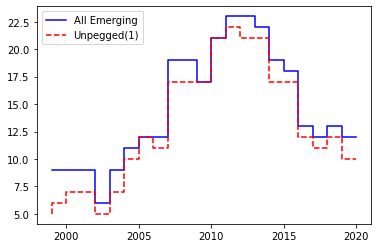

In [672]:
plt.step(Yearly_EmergingTickers.index,len_EmergingTickers,'-b',label = 'All Emerging')
plt.step(Yearly_EmergingTickers.index,len_UnpeggedTickers,'--r', label = 'Unpegged(1)')
plt.legend()

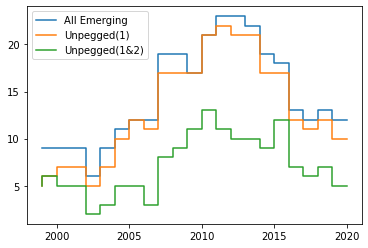

In [658]:
plt.step(Yearly_EmergingTickers.index,len_EmergingTickers,label = 'All Emerging')
plt.step(Yearly_EmergingTickers.index,len_UnpeggedTickers, label = 'Unpegged(1)')
plt.step(Yearly_EmergingTickers.index,len_Unpegged1and2Tickers, label = 'Unpegged(1&2)')
plt.legend()
#plt.savefig('Portfolios/TickerSizes.png')

# Correlation Analysis

In [32]:
#Correlation within each weight class. change rets for spot or excess. and 
                                    #change weight within loop for different weight class

#Rets = [[1,Returns_1M,RollingVolatility_1M],[3,Returns_3M,RollingVolatility_3M],\
#        [6,Returns_6M,RollingVolatility_6M],[9,Returns_9M,RollingVolatility_9M],\
#        [12,Returns_12M,RollingVolatility_12M]]
Rets = [[1,Excess_Returns_1M,RollingVolatility_1M],[3,Excess_Returns_3M,RollingVolatility_3M],\
        [6,Excess_Returns_6M,RollingVolatility_6M],[9,Excess_Returns_9M,RollingVolatility_9M],\
        [12,Excess_Returns_12M,RollingVolatility_12M]]

totalCorr_h1 = pd.DataFrame(0.,columns = [1,3,6,9,12],index = [1,3,6,9,12])
totalpval_h1 = pd.DataFrame(0.,columns = [1,3,6,9,12],index = [1,3,6,9,12])

longCorr_h1 = pd.DataFrame(0.,columns = [1,3,6,9,12],index = [1,3,6,9,12])
longpval_h1 = pd.DataFrame(0.,columns = [1,3,6,9,12],index = [1,3,6,9,12])

shortCorr_h1 = pd.DataFrame(0.,columns = [1,3,6,9,12],index = [1,3,6,9,12])
shortpval_h1 = pd.DataFrame(0.,columns = [1,3,6,9,12],index = [1,3,6,9,12])


for i in range(5):
    for j in range(5)[(i+1):]:
        total1,long1,short1 = CurrencyMomentumPortfolios(Yearly_EmergingTickers,Rets[i][1],Rets[0][1]\
             ,Rets[i][0],Rets[0][0],3,Rets[i][2],'returns','returns')
        total2,long2,short2 = CurrencyMomentumPortfolios(Yearly_EmergingTickers,Rets[j][1],Rets[0][1]\
             ,Rets[j][0],Rets[0][0],3,Rets[j][2],'returns','returns')
        diff = Rets[j][0]-Rets[i][0]

        totalCorr_h1.iloc[i,j] = st.pearsonr(total1.T.sum()[diff:],total2.T.sum())[0]
        totalpval_h1.iloc[i,j] = st.pearsonr(total1.T.sum()[diff:],total2.T.sum())[1]
    
        longCorr_h1.iloc[i,j] = st.pearsonr(long1.T.sum()[diff:],long2.T.sum())[0]
        longpval_h1.iloc[i,j] = st.pearsonr(long1.T.sum()[diff:],long2.T.sum())[1]
        #if j==4:#only use for spot returns[diff+1:]
        shortCorr_h1.iloc[i,j] = st.pearsonr(short1.T.sum()[diff:],short2.T.sum())[0]
        shortpval_h1.iloc[i,j] = st.pearsonr(short1.T.sum()[diff:],short2.T.sum())[1]

In [785]:
totalCorr_h1.to_excel('Portfolios/totalCORR.xlsx')
totalpval_h1.to_excel('Portfolios/totalPVAL.xlsx')
longCorr_h1.to_excel('Portfolios/longCORR.xlsx')
longpval_h1.to_excel('Portfolios/longPVAL.xlsx')
shortCorr_h1.to_excel('Portfolios/shortCORR.xlsx')
shortpval_h1.to_excel('Portfolios/shortPVAL.xlsx')

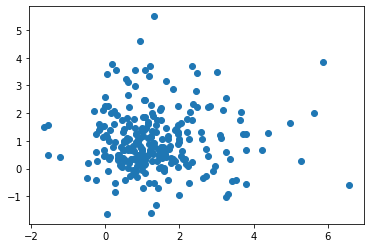

In [734]:
plt.scatter(a1.T.sum()[3:],b1.T.sum())

In [921]:
#Correlations across different factors - with 1 month holding 
Rets = [[1,Excess_Returns_1M,RollingVolatility_1M],[3,Excess_Returns_3M,RollingVolatility_3M],\
        [6,Excess_Returns_6M,RollingVolatility_6M],[9,Excess_Returns_9M,RollingVolatility_9M],\
        [12,Excess_Returns_12M,RollingVolatility_12M]]
#Rets = [[1,Returns_1M,RollingVolatility_1M],[3,Returns_3M,RollingVolatility_3M],\
#        [6,Returns_6M,RollingVolatility_6M],[9,Returns_9M,RollingVolatility_9M],\
#        [12,Returns_12M,RollingVolatility_12M]]
Corr_equalTS = pd.DataFrame(0.,columns = [1,3,6,9,12],index = ['h=1','pval'])
Corr_returnsTS = pd.DataFrame(0.,columns = [1,3,6,9,12],index = ['h=1','pval'])
Corr_sharpeTS = pd.DataFrame(0.,columns = [1,3,6,9,12],index = ['h=1','pval'])

Corr_equalCarry = pd.DataFrame(0.,columns = [1,3,6,9,12],index = ['h=1','pval'])
Corr_returnsCarry = pd.DataFrame(0.,columns = [1,3,6,9,12],index = ['h=1','pval'])
Corr_sharpeCarry = pd.DataFrame(0.,columns = [1,3,6,9,12],index = ['h=f','pval'])

Corr_equalValue = pd.DataFrame(0.,columns = [1,3,6,9,12],index = ['h=1','pval'])
Corr_returnsValue = pd.DataFrame(0.,columns = [1,3,6,9,12],index = ['h=1','pval'])
Corr_sharpeValue = pd.DataFrame(0.,columns = [1,3,6,9,12],index = ['h=1','pval'])

#TST = TSCurrencyMomentumPortfolios(Yearly_EmergingTickers,Excess_Returns_1M,Excess_Returns_1M,1,1,\
#                             RollingVolatility_1M,'returns','equal')[2].T.sum()
CT = CarryTrade()[0].T.sum()
VT = ValueTrade()[0].T.sum()
for i in range(5):
    diff = Rets[i][0]-1
    a1 = CurrencyMomentumPortfolios(Yearly_EmergingTickers,Rets[i][1],Excess_Returns_1M\
             ,Rets[i][0],1,3,Rets[i][2],'returns','equal')[0]
   # b1 = CurrencyMomentumPortfolios(Yearly_EmergingTickers,Rets[i][1],Excess_Returns_1M\
   #          ,Rets[i][0],1,3,Rets[i][2],'returns','returns')[0]
   # c1 = CurrencyMomentumPortfolios(Yearly_EmergingTickers,Rets[i][1],Excess_Returns_1M\
   #          ,Rets[i][0],1,3,Rets[i][2],'returns','sharpe')[0]   
    TST = TSCurrencyMomentumPortfolios(Yearly_EmergingTickers,Rets[i][1],Excess_Returns_1M,Rets[i][0],1,\
                             Rets[i][2],'returns','equal')[0].T.sum()
    
    Corr_equalTS.iloc[0,i] = st.pearsonr(a1.T.sum(),TST)[0]
    Corr_equalTS.iloc[1,i] = st.pearsonr(a1.T.sum(),TST)[1]
    #Corr_returnsTS.iloc[0,i] = st.pearsonr(b1.T.sum(),TST)[0]
    #Corr_returnsTS.iloc[1,i] = st.pearsonr(b1.T.sum(),TST)[1]   
    #Corr_sharpeTS.iloc[0,i] = st.pearsonr(c1.T.sum(),TST)[0]
    #Corr_sharpeTS.iloc[1,i] = st.pearsonr(c1.T.sum(),TST)[1]

    Corr_equalCarry.iloc[0,i] = st.pearsonr(a1.T.sum(),CT[diff:])[0]
    Corr_equalCarry.iloc[1,i] = st.pearsonr(a1.T.sum(),CT[diff:])[1]
    #Corr_returnsCarry.iloc[0,i] = st.pearsonr(b1.T.sum(),CT[diff:])[0]
    #Corr_returnsCarry.iloc[1,i] = st.pearsonr(b1.T.sum(),CT[diff:])[1]   
    #Corr_sharpeCarry.iloc[0,i] = st.pearsonr(c1.T.sum(),CT[diff:])[0]
    #Corr_sharpeCarry.iloc[1,i] = st.pearsonr(c1.T.sum(),CT[diff:])[1]
    
    Corr_equalValue.iloc[0,i] = st.pearsonr(a1.T.sum(),VT[diff:])[0]
    Corr_equalValue.iloc[1,i] = st.pearsonr(a1.T.sum(),VT[diff:])[1]
    #Corr_returnsValue.iloc[0,i] = st.pearsonr(b1.T.sum(),VT[diff:])[0]
    #Corr_returnsValue.iloc[1,i] = st.pearsonr(b1.T.sum(),VT[diff:])[1]   
    #Corr_sharpeValue.iloc[0,i] = st.pearsonr(c1.T.sum(),VT[diff:])[0]
    #Corr_sharpeValue.iloc[1,i] = st.pearsonr(c1.T.sum(),VT[diff:])[1]

In [913]:
Corr_equalTS.to_excel('Portfolios/corrTSequal.xlsx')
#Corr_returnsTS.to_excel('Portfolios/corrTSreturns.xlsx')
#Corr_sharpeTS.to_excel('Portfolios/corrTSsharpe.xlsx')

Corr_equalCarry.to_excel('Portfolios/corrCTequal.xlsx')
#Corr_returnsCarry.to_excel('Portfolios/corrCTreturns.xlsx')
#Corr_sharpeCarry.to_excel('Portfolios/corrCTsharpe.xlsx')

Corr_equalValue.to_excel('Portfolios/corrVTequal.xlsx')
#Corr_returnsValue.to_excel('Portfolios/corrVTreturns.xlsx')
#Corr_sharpeValue.to_excel('Portfolios/corrVTsharpe.xlsx')

# TS Mom Trend following

In [184]:
def TSCurrencyMomentumPortfolios(Yearly_EmergingTickers,Returns_fM,Returns_hM,f,h,\
                               RollingVolatility_fM, ranking_system, weighting_system):
    
    TSLongPortfolioReturns_f_h = pd.DataFrame(0.,columns = Returns_fM.columns,index=Returns_fM.index[1:])
    TSShortPortfolioReturns_f_h = pd.DataFrame(0.,columns = Returns_fM.columns,index=Returns_fM.index[1:])

    for i in np.arange(0,len(Returns_fM)-h,h):
        
        if i+h<len(Returns_hM):
        
            year_i = Returns_fM.index[i].year 

            if ranking_system == 'returns':
                ECReturnsi = Returns_fM.iloc[i][Yearly_EmergingTickers.loc[year_i][0]]
                winners = ECReturnsi[ECReturnsi>0]
                losers = ECReturnsi[ECReturnsi<0]

            if weighting_system == 'equal':
                Weights = pd.DataFrame([list(winners.index)+list(losers.index),[1/len(winners+losers)]*len(winners+losers)]\
                                   ,index = ['Tickers','Weights']).T.set_index('Tickers')

            elif weighting_system == 'sharpe':
                Weights = pd.DataFrame(columns = ['Tickers','Weights'])
                counter = 0
                for ticker in (list(winners.index)+list(losers.index)):
                    weight = RollingVolatility_fM[ticker].iloc[i]\
                    /RollingVolatility_fM[list(winners.index)+list(losers.index)].iloc[i].sum()
                    Weights.loc[counter] = [ticker,weight]
                    counter+=1
                Weights = Weights.set_index('Tickers')

            elif weighting_system == 'returns':
                weight = []
                totalweights = abs(Returns_fM[list(winners.index)+list(losers.index)].iloc[i]).sum()
                for ticker in (list(winners.index)+list(losers.index)):
                    weight.append([ticker,abs(Returns_fM[ticker].iloc[i])/totalweights])
                Weights = pd.DataFrame(weight,columns=['Tickers','Weights']).set_index('Tickers')

            for ticker in winners.index:
                TSLongPortfolioReturns_f_h.iloc[i][ticker] = Weights.loc[ticker]*Returns_hM.iloc[i+h][ticker]
            for ticker in losers.index:
                TSShortPortfolioReturns_f_h.iloc[i][ticker] = Weights.loc[ticker]*-Returns_hM.iloc[i+h][ticker]

    TSLongPortfolioReturns_f_h = TSLongPortfolioReturns_f_h.replace(0,np.nan)#.dropna(how='all',axis=0)
    TSShortPortfolioReturns_f_h = TSShortPortfolioReturns_f_h.replace(0,np.nan)#.dropna(how='all',axis=0)

    TSLongPortfolioReturns_f_h = TSLongPortfolioReturns_f_h.replace(np.nan,0)
    TSShortPortfolioReturns_f_h = TSShortPortfolioReturns_f_h.replace(np.nan,0)
    TSTotalPortfolioReturns_f_h = TSLongPortfolioReturns_f_h + TSShortPortfolioReturns_f_h
    
    return TSTotalPortfolioReturns_f_h, TSLongPortfolioReturns_f_h, TSShortPortfolioReturns_f_h


In [441]:
ExcessMarketReturnsREG = TSCurrencyMomentumPortfolios(Yearly_EmergingTickers,Excess_Returns_1M,Excess_Returns_1M,1,1,RollingVolatility_1M,'returns','returns')[0]

In [442]:
(ExcessMarketReturnsREG.T.sum()).to_excel('Portfolios/Market.xlsx')

In [381]:
TSTotal_3_1.T.sum().to_excel('Portfolios/Xehfubeuv.xlsx')

In [186]:
#TS Benchmark equivalent Excess Returns Results 1 holding period 
TSTotal_1_1,TSLong_1_1,TSShort_1_1 = TSCurrencyMomentumPortfolios(Yearly_EmergingTickers,Excess_Returns_1M,Excess_Returns_1M,1,1,RollingVolatility_1M,'returns','equal')
TSTotal_3_1,TSLong_3_1,TSShort_3_1 = TSCurrencyMomentumPortfolios(Yearly_EmergingTickers,Excess_Returns_3M,Excess_Returns_1M,3,1,RollingVolatility_3M,'returns','equal')
TSTotal_6_1,TSLong_6_1,TSShort_6_1 = TSCurrencyMomentumPortfolios(Yearly_EmergingTickers,Excess_Returns_6M,Excess_Returns_1M,6,1,RollingVolatility_6M,'returns','equal')
TSTotal_9_1,TSLong_9_1,TSShort_9_1 = TSCurrencyMomentumPortfolios(Yearly_EmergingTickers,Excess_Returns_9M,Excess_Returns_1M,9,1,RollingVolatility_9M,'returns','equal')
TSTotal_12_1,TSLong_12_1,TSShort_12_1 = TSCurrencyMomentumPortfolios(Yearly_EmergingTickers,Excess_Returns_12M,Excess_Returns_1M,12,1,RollingVolatility_12M,'returns','equal')

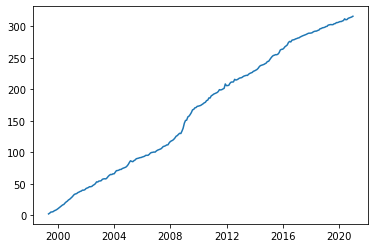

In [88]:
plt.plot(TSTotal_3_1.T.sum().cumsum());

# CarryTradeFactor

In [150]:
def CarryTrade():
    LongPortfolioReturns = pd.DataFrame(0.,columns = Returns_1M.columns,index=Returns_1M.index[1:])
    ShortPortfolioReturns = pd.DataFrame(0.,columns = Returns_1M.columns,index=Returns_1M.index[1:])
    #No_of_countries = len(IRD_1M)
    #returnsi = []
    tickers_topp = []
    tickers_bottomm = []
    Weights = []
    for year in IRD_1M.columns: 
        tickerstop = []
        tickersbottom = []
        size = len(Yearly_EmergingTickers.loc[int(year)][0])
        for ticker in Yearly_EmergingTickers.loc[int(year)][0]:
            topcarry = IRD_1M[year].nlargest(int(size/3)).index
            bottomcarry = IRD_1M[year].nsmallest(int(size/3)).index
        for country in topcarry:
            tickerstop.append(CountryToTickers[country])
        tickers_topp.append([tickerstop])
        for country in bottomcarry:
            tickersbottom.append(CountryToTickers[country])
        tickers_bottomm.append([tickersbottom])
        Weights.append([year,1/len(list(topcarry)+list(bottomcarry))])
    WEIGHTS = pd.DataFrame(Weights,columns = ['year','weight']).set_index('year')
    tickers_top = pd.DataFrame(tickers_topp,columns = ['toptickers'],index = IRD_1M.columns)
    tickers_bottom = pd.DataFrame(tickers_bottomm,columns = ['bottomtickers'],index = IRD_1M.columns)
    LongReturns = []
    ShortReturns = []
    for date in Returns_1M.index[1:]:   
        for ticker in tickers_top.loc[str(date.year)][0]:

            LongPortfolioReturns.loc[date,ticker] = Excess_Returns_1M.loc[date,ticker]*WEIGHTS.loc[str(date.year)][0]
            #LongReturns.append(Returns_1M[1:][ticker].loc[date])
        for ticker in tickers_bottom.loc[str(date.year)][0]:
    
            ShortPortfolioReturns.loc[date,ticker] = -1*(Excess_Returns_1M[1:].loc[date,ticker])*WEIGHTS.loc[str(date.year)][0]
            #ShortReturns.append(-Returns_1M[1:][ticker].loc[date])
    return LongPortfolioReturns+ShortPortfolioReturns, LongPortfolioReturns, ShortPortfolioReturns
CarryTradeTotal,CarryTradeLong,CarryTradeShort = CarryTrade()

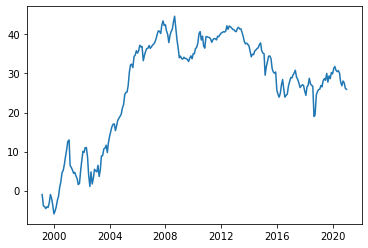

In [151]:
plt.plot(CarryTradeTotal.T.sum().cumsum())

# Value Trade

In [438]:
PPP = pd.read_excel('PPPData-ValFactor.xlsx',sheet_name = 'PPP')
PPP = PPP.iloc[:-1]

Tickers = []
for i in PPP.iloc[:,0]:
    Tickers.append(CountryToTickers[i])
PPP['Tickers'] = Tickers
PPP = PPP.set_index('Tickers')
PPP = PPP.iloc[:,1:]
print(PPP)
PPP = 1/PPP # Ratio compared to USD PPP - 'Real exchange rate'

                     1999      2000      2001      2002      2003      2004  \
Tickers                                                                       
USDDZD Curncy    0.204177  0.196863  0.208963  0.198357  0.191722  0.209932   
USDARS Curncy    0.693716  0.671284  0.663416  0.642064  0.257986  0.303832   
USDBDT Curncy    0.336110  0.324688  0.313972  0.295793  0.284243  0.292894   
USDBRL Curncy    0.593185  0.404074  0.413861  0.341251  0.296768  0.315442   
USDCLP Curncy    0.605461  0.552268  0.531205  0.458714  0.430294  0.440220   
USDCNY Curncy    0.338037  0.329049  0.328489  0.328070  0.324910  0.327290   
USDCOP Curncy    0.456602  0.411353  0.376732  0.356484  0.341493  0.311686   
USDCZK Curncy    0.433308  0.411619  0.371188  0.376491  0.441629  0.503054   
USDEUR Curncy.1  0.747079  0.717324  0.616807  0.598086  0.623910  0.774028   
USDHUF Curncy    0.456276  0.440851  0.389960  0.399287  0.458155  0.544514   
USDINR Curncy    0.223066  0.219986  0.211540  0.204

In [178]:
def ValueTrade():    
    LongPortfolioReturns = pd.DataFrame(0.,columns = Returns_1M.columns,index=Returns_1M.index[1:])
    ShortPortfolioReturns = pd.DataFrame(0.,columns = Returns_1M.columns,index=Returns_1M.index[1:])
    
    for date in Spot.index[2:]:
        valuefactor = []
        size = len(Yearly_EmergingTickers.loc[date.year][0])
        for ticker in Yearly_EmergingTickers.loc[date.year][0]:
            valuefactor.append([ticker,(PPP.loc[ticker,str(date.year)]-Spot.loc[str(date),ticker])\
                                               /Spot.loc[str(date),ticker]])
        winners = pd.DataFrame(valuefactor,columns = ['Tickers','Value']).set_index('Tickers')['Value']\
                        .nlargest(int(size/3)).index
        losers = pd.DataFrame(valuefactor,columns = ['Tickers','Value']).set_index('Tickers')['Value']\
                        .nsmallest(int(size/3)).index
        Weight = 1/len(list(winners)+list(losers))
        for ticker in winners:
            LongPortfolioReturns.loc[date,ticker] = Excess_Returns_1M.loc[date,ticker]*Weight
        for ticker in losers:
            ShortPortfolioReturns.loc[date,ticker] = -1*Excess_Returns_1M.loc[date,ticker]*Weight
    return LongPortfolioReturns+ShortPortfolioReturns, LongPortfolioReturns, ShortPortfolioReturns
ValueTradeTotal, ValueTradeLong, ValueTradeShort = ValueTrade()

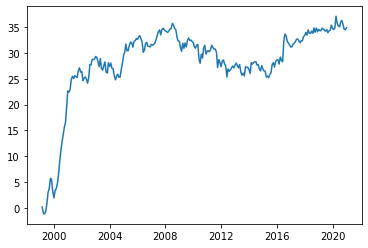

In [179]:
plt.plot(ValueTradeTotal.T.sum().cumsum())

# DOL Factor


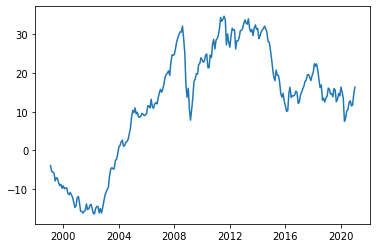

In [350]:
DOLReturns = Excess_Returns_1M.T.mean()
plt.plot(DOLReturns.cumsum())

# cross section excess returns for factor modelling

In [348]:
def PortfolioReturns(weighting):    
    PortfolioReturns1 = pd.DataFrame(0.,columns = Returns_1M.columns,index=Returns_1M.index)
    for yeari in list(Yearly_EmergingCountries.index):
        for country in list(Yearly_EmergingTickers.loc[yeari]):
            if weighting == 'equal':
                weight = 1/len(Yearly_EmergingTickers.loc[yeari][0])
                for i in range(len(PortfolioReturns1)):
                    if PortfolioReturns1.index[i].year == yeari:
                        PortfolioReturns1.iloc[i].loc[country] = Excess_Returns_1M.iloc[i].loc[country]*weight
            #elif weighting == 'return':
            #    for i in range(len(PortfolioReturns)):
            #        if PortfolioReturns.index[i].year == yeari:
            #            weight = 
            #            PortfolioReturns.iloc[i].loc[country] = Excess_Returns_1M.iloc[i].loc[country]
    return PortfolioReturns1

In [99]:
PortfolioExcessReturns = PortfolioReturns('equal')

In [445]:
Excess_Returns_1M.T.mean()

Dates
1999-01-29   -3.951976
1999-02-26   -1.485265
1999-03-31   -0.158008
1999-04-30   -0.231609
1999-05-31   -2.067058
                ...   
2020-08-31    0.491311
2020-09-30   -1.313475
2020-10-30    0.172496
2020-11-30    2.791318
2020-12-31    1.834381
Length: 264, dtype: float64

In [446]:
#plt.plot(PortfolioExcessReturns.T.sum().cumsum());
Excess_Returns_1M.T.mean().to_excel('Portfolios/Avg.xlsx')

In [209]:
RegressionDataNew = pd.DataFrame([PortfolioExcessReturns[3:].T.sum(),BenchmarkTotal_3_1.T.sum(),TSTotal_1_1[2:].T.sum(),\
                    CarryTradeTotal[2:].T.sum(),ValueTradeTotal[2:].T.sum()],index = ['Portfolio Returns','XMOM_3_1','TSMOM','CarryTradeReturns','ValueTradeReturns']).T
RegressionDataNew.to_excel(r"/Users/abbasmahmood/Desktop/Dissertation/Portfolios/regression_new.xlsx",index = True, header = True)


# Regressions

In [321]:
x = np.array(Excess_Returns_1M.T.mean()[1:]).reshape((-1, 1))
y = np.array(BenchmarkTotal_1_1.T.sum())
model = LinearRegression()
model.fit(x,y)
print(model.score(x,y),model.intercept_,model.coef_)

0.04288674384208302 0.21425121097930572 [-0.13630401]


In [192]:
x = np.array(BenchmarkTotal_1_1.T.sum()).reshape((-1, 1))
y = np.array(TSTotal_1_1.T.sum().values)
model = LinearRegression()
model.fit(x,y)
print(model.score(x,y),model.intercept_,model.coef_)

0.6920395074757499 0.07938062645298227 [0.87374461]


In [216]:
x = np.array(BenchmarkTotal_1_1.T.sum()).reshape((-1, 1))
y = np.array(CarryTradeTotal.T.sum().values)
model = LinearRegression()
model.fit(x,y)
print(model.score(x,y),model.intercept_,model.coef_)

0.0018600155329205892 0.2888165997584265 [-0.51870049]


In [212]:
x = np.array(BenchmarkTotal_3_1.T.sum()).reshape((-1, 1))
y = np.array(ValueTradeTotal[2:].T.sum().values)
model = LinearRegression()
model.fit(x,y)
print(model.score(x,y),model.intercept_,model.coef_)

0.0014820724227144755 0.3860389462487904 [0.3000515]


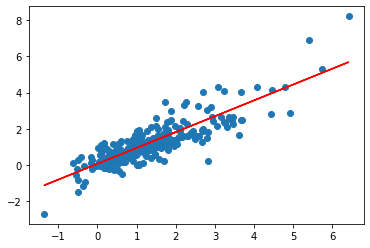

In [194]:
#plt.scatter(BenchmarkLong_3_1.T.sum(),TSLong_3_1.T.sum())
#x = np.array(BenchmarkTotal_1_1.T.sum()).reshape((-1, 1))
#y = np.array(TSTotal_1_1.T.sum().values)
#model = LinearRegression()
#model.fit(x,y)
plt.scatter(BenchmarkTotal_3_1.T.sum(),TSTotal_3_1.T.sum())
plt.plot(BenchmarkTotal_3_1.T.sum(),model.coef_*BenchmarkTotal_3_1.T.sum()+model.intercept_,'red')

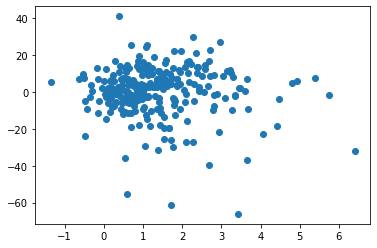

In [217]:
plt.scatter(BenchmarkTotal_3_1.T.sum(),CarryTradeTotal[2:].T.sum())

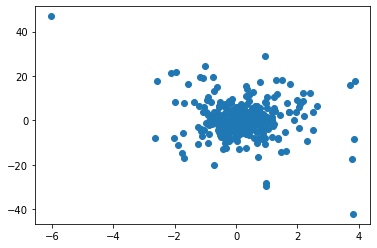

In [213]:
plt.scatter(BenchmarkTotal_1_1.T.sum(),ValueTradeTotal[:].T.sum())

In [221]:
RegressionData = pd.DataFrame([Excess_Returns_1M.T.mean()[1:],BenchmarkTotal_1_1.T.sum(),TSTotal_1_1.T.sum(),\
                    CarryTradeTotal.T.sum(),ValueTradeTotal.T.sum()],index = ['DOL','MomReturns','TSReturns','CarryReturns','ValueReturns']).T
#RegressionData.to_excel(r"/Users/abbasmahmood/Desktop/Dissertation/Portfolios/regression_1_1.xlsx",index = True, header = True)


In [322]:
RegressionData2 = pd.DataFrame([Excess_Returns_1M.T.mean()[3:],BenchmarkTotal_3_1.T.sum(),TSTotal_3_1.T.sum(),\
                    CarryTradeTotal[2:].T.sum(),ValueTradeTotal[2:].T.sum()],index = ['DOL','MomReturns','TSMOM','HML','VAL']).T
#RegressionData2.to_excel(r"/Users/abbasmahmood/Desktop/Dissertation/Portfolios/regression_3_1.xlsx",index = True, header = True)


In [656]:
#Regress over Long portfolio
RegressionDataLong = pd.DataFrame([Excess_Returns_1M.T.mean()[3:],BenchmarkLong_3_1.T.sum(),TSLong_3_1.T.sum(),\
                    CarryTradeLong[2:].T.sum(),ValueTradeLong[2:].T.sum()],index = ['DOL','XMOM','TSMOM','HML','VAL']).T
RegressionDataLong.to_excel(r"/Users/abbasmahmood/Desktop/Dissertation/Portfolios/regression_3_1LONG.xlsx",index = True, header = True)


In [657]:
#Regress over Short portfolio
RegressionDataShort = pd.DataFrame([Excess_Returns_1M.T.mean()[3:],BenchmarkShort_3_1.T.sum(),TSShort_3_1.T.sum(),\
                    CarryTradeShort[2:].T.sum(),ValueTradeShort[2:].T.sum()],index = ['DOL','XMOM','TSMOM','HML','VAL']).T
RegressionDataShort.to_excel(r"/Users/abbasmahmood/Desktop/Dissertation/Portfolios/regression_3_1SHORT.xlsx",index = True, header = True)



# Descriptive Analysis

In [306]:
Spread_pct

,USDPLN Curncy,USDZAR Curncy,USDCLP Curncy,USDNGN Curncy,USDKRW Curncy,USDEUR Curncy,USDKZT Curncy,USDCNY Curncy,USDPHP Curncy,USDNZD Curncy,...,USDVND Curncy,USDILS Curncy,USDCZK Curncy,USDRUB Curncy,USDTHB Curncy,USDRON Curncy,USDUAH Curncy,USDTRY Curncy,USDPEN Curncy,USDPKR Curncy
Dates,,,,,,,,,,,,,,,,,,,,,
1998-12-31,0.284900,0.340861,0.000000,0.000000,0.000000,0.034994,0.000000,0.000000,0.000000,0.206448,...,0.028794,0.000000,0.132499,0.000000,0.272851,0.000000,0.000000,0.095087,0.095042,0.000000
1999-01-29,0.136277,0.156706,0.102218,0.000000,0.000000,0.022725,0.000000,0.000000,0.000000,6.658420,...,0.021611,0.000000,0.154088,0.435730,0.135740,0.000000,0.000000,0.059934,0.119367,0.100908
1999-02-26,2.534854,0.322971,0.199104,1.445087,0.245349,0.055145,0.000000,0.024158,1.026958,2.468617,...,0.722022,0.000000,0.070032,0.650054,0.000000,0.000000,0.000000,0.141123,0.586510,0.000000
1999-03-31,2.503129,0.121797,0.103040,0.000000,0.000000,0.043048,0.000000,0.020531,1.032258,6.741573,...,0.000000,0.000000,0.084215,0.603015,1.331558,0.000000,0.000000,1.608148,0.120012,0.000000
1999-04-30,0.126502,0.123532,0.103231,0.000000,0.000000,0.042279,0.000000,0.000000,0.000000,2.989829,...,0.000000,0.144207,0.084398,0.000000,0.269542,0.000000,0.000000,2.396907,0.059916,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-08-31,0.149282,0.080866,0.090131,0.199849,0.025256,NaN,0.311890,0.030664,0.146371,NaN,...,0.125183,0.095397,0.118174,0.076686,0.048204,0.165293,0.063541,0.575957,0.070568,0.445952
2020-09-30,0.230236,0.268085,0.084148,0.459161,0.017100,NaN,0.231214,0.035342,0.039186,NaN,...,0.012940,0.087558,0.216032,0.047016,0.126263,0.170743,1.033449,0.498983,0.194310,0.120736
2020-10-30,0.353812,0.576216,0.031013,0.542209,0.026428,NaN,0.124804,0.017933,0.020659,NaN,...,0.008629,1.087913,0.473273,0.029548,0.048119,0.282574,0.300698,1.385277,0.041490,0.004867


In [320]:
DescriptiveStats = pd.DataFrame((((((Excess_Returns_1M.mean()/100)+1)**12)-1)*100),columns = ['Annualised mean ExRets pct'])
DescriptiveStats['Country'] = Unique_Countries
DescriptiveStats = DescriptiveStats.reset_index().set_index('Country')
DescriptiveStats['Annualised std ExRets pct'] = np.array(Returns_1M.std()*np.sqrt(12))
DescriptiveStats['Avgspreadpct'] = ((((((np.array(Spread_pct.mean())/100)+1)**12)-1)*100))
DescriptiveStats['Stdspreadpct'] = np.array(Spread_pct.std()*np.sqrt(12))
#DescriptiveStats['Max'] = np.array((Excess_Returns_1M).max()) #(((((Excess_Returns_1M/100)+1)**12)-1)*100).max()
#DescriptiveStats['Min'] = np.array((Excess_Returns_1M).min())
DescriptiveStats = DescriptiveStats.sort_index()
DescriptiveStats['Avg annualised IRD'] = IRD_12M.T.mean()
DescriptiveStats['std annualised IRD'] = IRD_12M.T.std()

#DescriptiveStats.to_excel('Portfolios/DescriptiveStats1.xlsx')


In [321]:
DescriptiveStats

,index,Annualised mean ExRets pct,Annualised std ExRets pct,Avgspreadpct,Stdspreadpct,Avg annualised IRD,std annualised IRD
Country,,,,,,,
Algeria,USDDZD Curncy,1.878484,6.805727,24.991739,7.347180,5.914240,2.936348
Argentina,USDARS Curncy,-7.410760,23.285699,1.448601,1.125408,17.050390,16.198937
Bangladesh,USDBDT Curncy,0.705653,3.649689,4.056364,2.133604,3.437500,1.707716
Brazil,USDBRL Curncy,0.847138,23.099887,0.957941,0.295013,10.484037,5.151662
Chile,USDCLP Curncy,-0.581958,12.033954,1.248382,0.423652,2.028409,2.342647
China,USDCNY Curncy,1.672033,2.723182,0.415092,0.217462,0.610227,2.026736
Colombia,USDCOP Curncy,-0.267039,13.188387,1.608136,0.492551,4.369318,1.979988
Czech Republic,USDCZK Curncy,0.865104,12.062658,2.965825,0.708394,0.028409,1.289802
Greece,USDEUR Curncy.1,0.332921,9.718159,0.424541,0.126566,0.588799,1.483901


In [23]:
(((((BenchmarkTotal_3_1.mean()/100)+1)**12)-1)*100)

USDPLN Curncy      1.891055
USDZAR Curncy      0.115692
USDCLP Curncy      0.967774
USDNGN Curncy      0.755169
USDKRW Curncy      0.419732
USDEUR Curncy      0.151501
USDKZT Curncy      0.394597
USDCNY Curncy      0.226759
USDPHP Curncy      0.209885
USDNZD Curncy      0.184433
USDINR Curncy      0.774256
USDBDT Curncy      0.005950
USDMYR Curncy      0.337626
USDIDR Curncy      0.579612
USDCOP Curncy      1.130509
USDMXN Curncy      0.336601
USDDZD Curncy      0.115702
USDEUR Curncy.1    0.013532
USDARS Curncy      0.657915
USDBRL Curncy      0.536959
USDHUF Curncy      0.674145
USDVND Curncy      0.022901
USDILS Curncy      0.221709
USDCZK Curncy      1.086764
USDRUB Curncy      0.993702
USDTHB Curncy      0.334840
USDRON Curncy      0.613515
USDUAH Curncy      0.337108
USDTRY Curncy      1.698605
USDPEN Curncy      0.093222
USDPKR Curncy      0.594318
dtype: float64

# Different Split sizes

In [318]:
#Excess Returns with different splits. Change split inside loop.
Rets = [[1,Excess_Returns_1M,RollingVolatility_1M],[3,Excess_Returns_3M,RollingVolatility_3M],\
        [6,Excess_Returns_6M,RollingVolatility_6M],[9,Excess_Returns_9M,RollingVolatility_9M],\
        [12,Excess_Returns_12M,RollingVolatility_12M]]

TotalAverageReturns_df = pd.DataFrame(0.,columns = [1,3,6,9,12],index=[1,3,6,9,12])
LongAverageReturns_df = pd.DataFrame(0.,columns = [1,3,6,9,12],index=[1,3,6,9,12])
ShortAverageReturns_df = pd.DataFrame(0.,columns = [1,3,6,9,12],index=[1,3,6,9,12])
TotalPval = pd.DataFrame(columns = [1,3,6,9,12],index=[1,3,6,9,12])
LongPval = pd.DataFrame(columns = [1,3,6,9,12],index=[1,3,6,9,12])
ShortPval = pd.DataFrame(columns = [1,3,6,9,12],index=[1,3,6,9,12])

AnnualizedSharpeRatiosTotal_df = pd.DataFrame(0.,columns = [1,3,6,9,12],index=[1,3,6,9,12])
AnnualizedSharpeRatiosLong_df = pd.DataFrame(0.,columns = [1,3,6,9,12],index=[1,3,6,9,12])
AnnualizedSharpeRatiosShort_df = pd.DataFrame(0.,columns = [1,3,6,9,12],index=[1,3,6,9,12])
SharpeTotalpval = pd.DataFrame(columns = [1,3,6,9,12],index=[1,3,6,9,12])
SharpeLongpval = pd.DataFrame(columns = [1,3,6,9,12],index=[1,3,6,9,12])
SharpeShortpval = pd.DataFrame(columns = [1,3,6,9,12],index=[1,3,6,9,12])


for i in range(5): #f
    for j in range(5): #h
        total,long,short = CurrencyMomentumPortfolios(Yearly_EmergingTickers,Rets[i][1],\
                            Rets[j][1],Rets[i][0],Rets[j][0],9,Rets[i][2],'returns','equal')

        TotalAverageReturns_df.iloc[i,j] = ((((total.T.sum().mean()/100)+1)**(12/Rets[j][0])-1)*100)
        LongAverageReturns_df.iloc[i,j] = ((((long.T.sum().mean()/100)+1)**(12/Rets[j][0])-1)*100)
        ShortAverageReturns_df.iloc[i,j] = ((((short.T.sum().mean()/100)+1)**(12/Rets[j][0])-1)*100)        
        TotalPval.iat[i,j] = st.ttest_1samp(total.T.sum(),0)[1]
        LongPval.iat[i,j] = st.ttest_1samp(long.T.sum(),0)[1]
        ShortPval.iat[i,j] = st.ttest_1samp(short.T.sum(),0)[1]
        
        AnnualizedSharpeRatiosTotal_df.iloc[i,j] = ((((total.T.sum().mean()/100)+1)**(12/Rets[j][0])-1)*100)/(total.T.sum().std()*np.sqrt(12/Rets[j][0]))
        AnnualizedSharpeRatiosLong_df.iloc[i,j] = ((((long.T.sum().mean()/100)+1)**(12/Rets[j][0])-1)*100)/(long.T.sum().std()*np.sqrt(12/Rets[j][0]))
        AnnualizedSharpeRatiosShort_df.iloc[i,j] = ((((short.T.sum().mean()/100)+1)**(12/Rets[j][0])-1)*100)/(short.T.sum().std()*np.sqrt(12/Rets[j][0]))
        SharpeTotalpval.iloc[i,j] = st.ttest_1samp(total.T.sum()/total.T.std(),0)[1]
        SharpeLongpval.iloc[i,j] = st.ttest_1samp(long.T.sum()/long.T.std(),0)[1]
        SharpeShortpval.iloc[i,j] = st.ttest_1samp(short.T.sum()/short.T.std(),0)[1]

In [319]:
TotalAverageReturns_df.to_excel('Portfolios/TotalReturnsSplit.xlsx',sheet_name='9Split')
ShortAverageReturns_df.to_excel('Portfolios/Short.xlsx',sheet_name='Short')
LongAverageReturns_df.to_excel('Portfolios/Long.xlsx',sheet_name='Long')
TotalPval.to_excel('Portfolios/TotalP.xlsx',sheet_name='Long')
LongPval.to_excel('Portfolios/LongP.xlsx',sheet_name='Long')
ShortPval.to_excel('Portfolios/ShortP.xlsx',sheet_name='Long')

AnnualizedSharpeRatiosTotal_df.to_excel('Portfolios/TotalSharpe.xlsx',sheet_name='Long')
AnnualizedSharpeRatiosLong_df.to_excel('Portfolios/LongSharpe.xlsx',sheet_name='Long')
AnnualizedSharpeRatiosShort_df.to_excel('Portfolios/ShortSharpe.xlsx',sheet_name='Long')
SharpeTotalpval.to_excel('Portfolios/TotalSharpePVAL.xlsx',sheet_name='Long')
SharpeLongpval.to_excel('Portfolios/LongSharpePVAL.xlsx',sheet_name='Long')
SharpeShortpval.to_excel('Portfolios/ShortSharpePVAL.xlsx',sheet_name='Long')

# Results after removing pegged

In [287]:
#Excess returns after removing pegged countries - based on /compared to benchmark only. Change peg setting within loop.

Rets = [[1,Excess_Returns_1M,RollingVolatility_1M],[3,Excess_Returns_3M,RollingVolatility_3M],\
        [6,Excess_Returns_6M,RollingVolatility_6M],[9,Excess_Returns_9M,RollingVolatility_9M],\
        [12,Excess_Returns_12M,RollingVolatility_12M]]

TotalAverageReturns_df = pd.DataFrame(0.,columns = [1,3,6,9,12],index=[1,3,6,9,12])
LongAverageReturns_df = pd.DataFrame(0.,columns = [1,3,6,9,12],index=[1,3,6,9,12])
ShortAverageReturns_df = pd.DataFrame(0.,columns = [1,3,6,9,12],index=[1,3,6,9,12])
TotalPval = pd.DataFrame(columns = [1,3,6,9,12],index=[1,3,6,9,12])
LongPval = pd.DataFrame(columns = [1,3,6,9,12],index=[1,3,6,9,12])
ShortPval = pd.DataFrame(columns = [1,3,6,9,12],index=[1,3,6,9,12])

AnnualizedSharpeRatiosTotal_df = pd.DataFrame(0.,columns = [1,3,6,9,12],index=[1,3,6,9,12])
AnnualizedSharpeRatiosLong_df = pd.DataFrame(0.,columns = [1,3,6,9,12],index=[1,3,6,9,12])
AnnualizedSharpeRatiosShort_df = pd.DataFrame(0.,columns = [1,3,6,9,12],index=[1,3,6,9,12])
SharpeTotalpval = pd.DataFrame(columns = [1,3,6,9,12],index=[1,3,6,9,12])
SharpeLongpval = pd.DataFrame(columns = [1,3,6,9,12],index=[1,3,6,9,12])
SharpeShortpval = pd.DataFrame(columns = [1,3,6,9,12],index=[1,3,6,9,12])


for i in range(5): #f
    for j in range(5): #h
        total,long,short = CurrencyMomentumPortfolios(Yearly_Unpegged1and2Tickers,Rets[i][1],\
                            Rets[j][1],Rets[i][0],Rets[j][0],3,Rets[i][2],'returns','equal')
        
        TotalAverageReturns_df.iloc[i,j] = ((((total.T.sum().mean()/100)+1)**(12/Rets[j][0])-1)*100)
        LongAverageReturns_df.iloc[i,j] = ((((long.T.sum().mean()/100)+1)**(12/Rets[j][0])-1)*100)
        ShortAverageReturns_df.iloc[i,j] = ((((short.T.sum().mean()/100)+1)**(12/Rets[j][0])-1)*100)        
        TotalPval.iat[i,j] = st.ttest_1samp(total.T.sum(),0)[1]
        LongPval.iat[i,j] = st.ttest_1samp(long.T.sum(),0)[1]
        ShortPval.iat[i,j] = st.ttest_1samp(short.T.sum(),0)[1]
        
        AnnualizedSharpeRatiosTotal_df.iloc[i,j] = ((((total.T.sum().mean()/100)+1)**(12/Rets[j][0])-1)*100)/(total.T.sum().std()*np.sqrt(12/Rets[j][0]))
        AnnualizedSharpeRatiosLong_df.iloc[i,j] = ((((long.T.sum().mean()/100)+1)**(12/Rets[j][0])-1)*100)/(long.T.sum().std()*np.sqrt(12/Rets[j][0]))
        AnnualizedSharpeRatiosShort_df.iloc[i,j] = ((((short.T.sum().mean()/100)+1)**(12/Rets[j][0])-1)*100)/(short.T.sum().std()*np.sqrt(12/Rets[j][0]))
        SharpeTotalpval.iloc[i,j] = st.ttest_1samp(total.T.sum()/total.T.std(),0)[1]
        SharpeLongpval.iloc[i,j] = st.ttest_1samp(long.T.sum()/long.T.std(),0)[1]
        SharpeShortpval.iloc[i,j] = st.ttest_1samp(short.T.sum()/short.T.std(),0)[1]
                

In [289]:
TotalAverageReturns_df.to_excel('Portfolios/TotalReturnsUnpegged.xlsx',sheet_name='Total')
ShortAverageReturns_df.to_excel('Portfolios/Short.xlsx',sheet_name='Short')
LongAverageReturns_df.to_excel('Portfolios/Long.xlsx',sheet_name='Long')
TotalPval.to_excel('Portfolios/TotalP.xlsx',sheet_name='Long')
LongPval.to_excel('Portfolios/LongP.xlsx',sheet_name='Long')
ShortPval.to_excel('Portfolios/ShortP.xlsx',sheet_name='Long')

AnnualizedSharpeRatiosTotal_df.to_excel('Portfolios/TotalSharpe.xlsx',sheet_name='Long')
AnnualizedSharpeRatiosLong_df.to_excel('Portfolios/LongSharpe.xlsx',sheet_name='Long')
AnnualizedSharpeRatiosShort_df.to_excel('Portfolios/ShortSharpe.xlsx',sheet_name='Long')
SharpeTotalpval.to_excel('Portfolios/TotalSharpePVAL.xlsx',sheet_name='Long')
SharpeLongpval.to_excel('Portfolios/LongSharpePVAL.xlsx',sheet_name='Long')
SharpeShortpval.to_excel('Portfolios/ShortSharpePVAL.xlsx',sheet_name='Long')


# Double Sort by volatility

In [357]:
YearlyEmergingHighVol = []
YearlyEmergingLowVol = []
list98on = [1998]+list(Yearly_EmergingCountries.index[:-1])
list99on =  list(Yearly_EmergingCountries.index)
for i in range(len(Yearly_EmergingCountries.index)):
    VolList = []
    for date in RollingVolatility_12MRAW.index:
        if (date.year == list98on[i])&(date.month == 12):
            for ticker in Yearly_EmergingTickers.loc[list99on[i]]['EmergingCountries']:
                #print(RollingVolatility_12MRAW.loc[date,ticker])
                VolList.append([ticker,RollingVolatility_12MRAW.loc[date,ticker]])
    lengthi = len(Yearly_EmergingCountries.iloc[i]['EmergingCountries'])
    EmergingCountryVol = pd.DataFrame(VolList,columns = ['tickers','values']).set_index('tickers')
    winners = list(EmergingCountryVol['values'].nlargest(int(np.floor(lengthi/2))).index)
    losers = list(EmergingCountryVol['values'].nsmallest(int(np.floor(lengthi/2))).index)
    YearlyEmergingHighVol.append([list99on[i],winners])
    YearlyEmergingLowVol.append([list99on[i],losers])
    
Yearly_EmergingHighVol = pd.DataFrame(YearlyEmergingHighVol,columns = ['year','tickers']).set_index('year')
Yearly_EmergingLowVol = pd.DataFrame(YearlyEmergingLowVol,columns = ['year','tickers']).set_index('year')

# Volatility Factor

In [471]:
Yearly_EmergingLowVol.loc[2000][0]

['USDCNY Curncy', 'USDARS Curncy', 'USDCLP Curncy', 'USDMYR Curncy']

In [486]:
VOLFactor = []
for yr in Yearly_EmergingHighVol['tickers'].index:
    weight = 1/(len(Yearly_EmergingHighVol['tickers'][year])*2)
    LosersReturns = Excess_Returns_1M[Yearly_EmergingHighVol.loc[yr][0]].T.sum()\
                [Excess_Returns_1M[Yearly_EmergingHighVol.loc[yr][0]].T.sum().index.year == yr]
    WinnersReturns = Excess_Returns_1M[Yearly_EmergingLowVol.loc[yr][0]].T.sum()\
                [Excess_Returns_1M[Yearly_EmergingLowVol.loc[yr][0]].T.sum().index.year == yr]
    for i in range(len(WinnersReturns)):
        VOLFactor.append(weight*WinnersReturns[i]-(weight*LosersReturns[i]))

In [491]:
pd.DataFrame(VOLFactor).to_excel('Portfolios/VOLFactor.xlsx')

<AxesSubplot:>

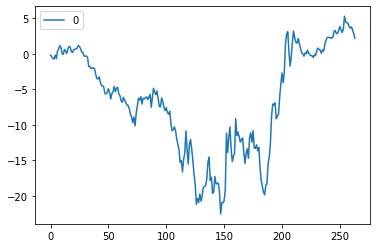

In [490]:
pd.DataFrame(VOLFactor).cumsum().plot()

In [596]:
#Running Momentum Equal weight ExcessReturns on HighVol and LowVol - change ticker setting inside loop for highvol vs lowvol.
Rets = [[1,Excess_Returns_1M,RollingVolatility_1M],[3,Excess_Returns_3M,RollingVolatility_3M],\
        [6,Excess_Returns_6M,RollingVolatility_6M],[9,Excess_Returns_9M,RollingVolatility_9M],\
        [12,Excess_Returns_12M,RollingVolatility_12M]]

TotalAverageReturns_df = pd.DataFrame(0.,columns = [1,3,6,9,12],index=[1,3,6,9,12])
LongAverageReturns_df = pd.DataFrame(0.,columns = [1,3,6,9,12],index=[1,3,6,9,12])
ShortAverageReturns_df = pd.DataFrame(0.,columns = [1,3,6,9,12],index=[1,3,6,9,12])
TotalPval = pd.DataFrame(columns = [1,3,6,9,12],index=[1,3,6,9,12])
LongPval = pd.DataFrame(columns = [1,3,6,9,12],index=[1,3,6,9,12])
ShortPval = pd.DataFrame(columns = [1,3,6,9,12],index=[1,3,6,9,12])

AnnualizedSharpeRatiosTotal_df = pd.DataFrame(0.,columns = [1,3,6,9,12],index=[1,3,6,9,12])
AnnualizedSharpeRatiosLong_df = pd.DataFrame(0.,columns = [1,3,6,9,12],index=[1,3,6,9,12])
AnnualizedSharpeRatiosShort_df = pd.DataFrame(0.,columns = [1,3,6,9,12],index=[1,3,6,9,12])
SharpeTotalpval = pd.DataFrame(columns = [1,3,6,9,12],index=[1,3,6,9,12])
SharpeLongpval = pd.DataFrame(columns = [1,3,6,9,12],index=[1,3,6,9,12])
SharpeShortpval = pd.DataFrame(columns = [1,3,6,9,12],index=[1,3,6,9,12])


for i in range(5): #f
    for j in range(5): #h
        total,long,short = CurrencyMomentumPortfolios(Yearly_EmergingLowVol,Rets[i][1],\
                            Rets[j][1],Rets[i][0],Rets[j][0],3,Rets[i][2],'returns','equal')
        
        TotalAverageReturns_df.iloc[i,j] = ((((total.T.sum().mean()/100)+1)**(12/Rets[j][0])-1)*100)
        LongAverageReturns_df.iloc[i,j] = ((((long.T.sum().mean()/100)+1)**(12/Rets[j][0])-1)*100)
        ShortAverageReturns_df.iloc[i,j] = ((((short.T.sum().mean()/100)+1)**(12/Rets[j][0])-1)*100)        
        TotalPval.iat[i,j] = st.ttest_1samp(total.T.sum(),0)[1]
        LongPval.iat[i,j] = st.ttest_1samp(long.T.sum(),0)[1]
        ShortPval.iat[i,j] = st.ttest_1samp(short.T.sum(),0)[1]
        
        AnnualizedSharpeRatiosTotal_df.iloc[i,j] = ((((total.T.sum().mean()/100)+1)**(12/Rets[j][0])-1)*100)/(total.T.sum().std()*np.sqrt(12/Rets[j][0]))
        AnnualizedSharpeRatiosLong_df.iloc[i,j] = ((((long.T.sum().mean()/100)+1)**(12/Rets[j][0])-1)*100)/(long.T.sum().std()*np.sqrt(12/Rets[j][0]))
        AnnualizedSharpeRatiosShort_df.iloc[i,j] = ((((short.T.sum().mean()/100)+1)**(12/Rets[j][0])-1)*100)/(short.T.sum().std()*np.sqrt(12/Rets[j][0]))
        SharpeTotalpval.iloc[i,j] = st.ttest_1samp(total.T.sum()/total.T.std(),0)[1]
        SharpeLongpval.iloc[i,j] = st.ttest_1samp(long.T.sum()/long.T.std(),0)[1]
        SharpeShortpval.iloc[i,j] = st.ttest_1samp(short.T.sum()/short.T.std(),0)[1]

In [597]:
TotalAverageReturns_df.to_excel('Portfolios/TotalReturnsLowVol.xlsx',sheet_name='Total')
ShortAverageReturns_df.to_excel('Portfolios/Short.xlsx',sheet_name='Short')
LongAverageReturns_df.to_excel('Portfolios/Long.xlsx',sheet_name='Long')
TotalPval.to_excel('Portfolios/TotalP.xlsx',sheet_name='Long')
LongPval.to_excel('Portfolios/LongP.xlsx',sheet_name='Long')
ShortPval.to_excel('Portfolios/ShortP.xlsx',sheet_name='Long')

AnnualizedSharpeRatiosTotal_df.to_excel('Portfolios/TotalSharpe.xlsx',sheet_name='Long')
AnnualizedSharpeRatiosLong_df.to_excel('Portfolios/LongSharpe.xlsx',sheet_name='Long')
AnnualizedSharpeRatiosShort_df.to_excel('Portfolios/ShortSharpe.xlsx',sheet_name='Long')
SharpeTotalpval.to_excel('Portfolios/TotalSharpePVAL.xlsx',sheet_name='Long')
SharpeLongpval.to_excel('Portfolios/LongSharpePVAL.xlsx',sheet_name='Long')
SharpeShortpval.to_excel('Portfolios/ShortSharpePVAL.xlsx',sheet_name='Long')

# Structural break and cumulative analysis

In [654]:
(BenchmarkTotal_1_1.T.sum().cumsum()).to_excel('Portfolios/Mom_1_1Analysis.xlsx')
#(BenchmarkTotal_3_1.T.sum().cumsum()).to_excel('Portfolios/Mom_3_1Analysis.xlsx')

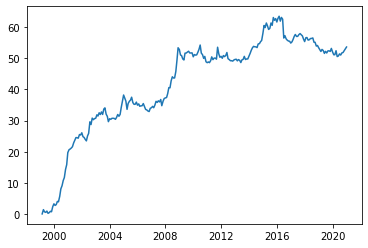

In [622]:
plt.plot(BenchmarkTotal_1_1.T.sum().cumsum())

In [649]:
PctUp = 100*np.sum(BenchmarkTotal_1_1.T.sum()>0)/len(BenchmarkTotal_1_1.T.sum())
PctDown = 100*np.sum(BenchmarkTotal_1_1.T.sum()<0)/len(BenchmarkTotal_1_1.T.sum())

# Exploring the different the ranking method